In [2]:
import pandas as pd
df = pd.read_csv('./data/customersegdata.csv',encoding='unicode_escape')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Background 

The informative features in this dataset that tell us about customer buying behavior include “Quantity”, “InvoiceDate” and “UnitPrice.” Using these variables, we are going to derive a customer’s RFM profile - Recency, Frequency, Monetary Value.

RFM is commonly used in marketing to evaluate a client’s value based on their:

Recency: How recently have they made a purchase?
Frequency: How often have they bought something?
Monetary Value: How much money do they spend on average when making purchases?

## 1. Calculating Recency

In [12]:
# convert date column to datetime format
df['Date']= pd.to_datetime(df['InvoiceDate'])
# keep only the most recent date of purchase
df['rank'] = df.sort_values(['CustomerID','Date']).groupby(['CustomerID'])['Date'].rank(method='min')
df_rec = df[df['rank']==1]

In [13]:
df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days

/var/folders/ng/bwk7d4ds7wz95l011dbvtc9r0000gn/T/ipykernel_25725/3505644634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days


## calculating frequency

In [14]:
freq = df_rec.groupby('CustomerID')['Date'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID','frequency']

In [15]:
rec_freq = df_freq.merge(df_rec,on='CustomerID')

## calculating monetary value

In [16]:
rec_freq['total'] = rec_freq['Quantity']*df['UnitPrice']
m = rec_freq.groupby('CustomerID')['total'].sum()
m = pd.DataFrame(m).reset_index()
m.columns = ['CustomerID','monetary_value']

In [17]:
rfm = m.merge(rec_freq,on='CustomerID')

In [18]:
finaldf = rfm[['CustomerID','recency','frequency','monetary_value']]

## removing outliers

recency: 


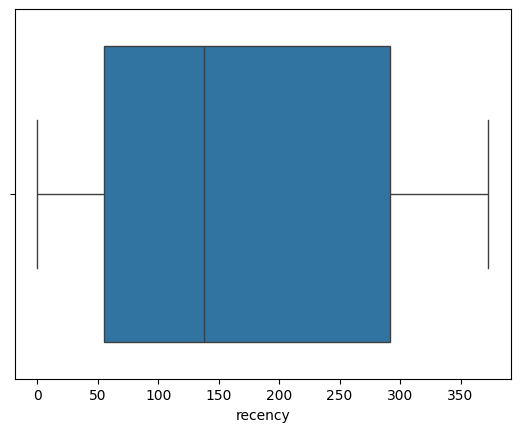

frequency: 


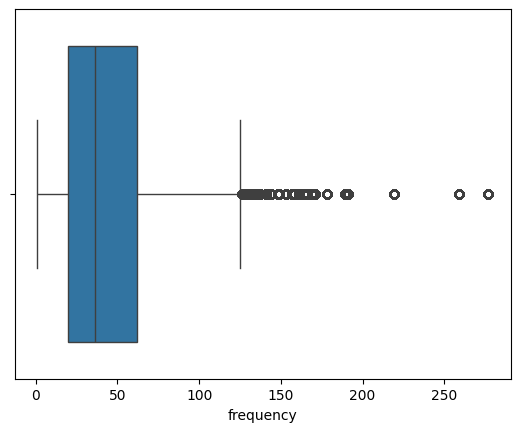

monetary_value: 


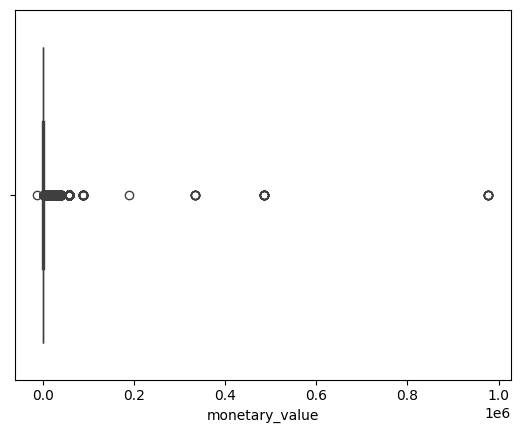

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
list1 = ['recency','frequency','monetary_value']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=finaldf[str(i)])
    plt.show()


## Z-Scoring for outlier detection and standardization

In [20]:
from scipy import stats
import numpy as np
# remove the customer id column
new_df = finaldf[['recency','frequency','monetary_value']]
# remove outliers
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]

In [21]:
from sklearn.preprocessing import StandardScaler
new_df = new_df.drop_duplicates()
col_names = ['recency', 'frequency', 'monetary_value']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

## Applying K-means clustering for customer segmentation problem

The goal of a K-Means clustering model is to segment all the data available into non-overlapping sub-groups that are distinct from each other.

When building a clustering model, we need to decide how many segments we want to group the data into. This is achieved by a heuristic called the elbow method.

We will create a loop and run the K-Means algorithm from 1 to 10 clusters. Then, we can plot model results for this range of values and select the elbow of the curve as the number of clusters to use.

Run the following lines of code to achieve this:

## Elbow method for optimal number of clusters

/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/sklearn/cluster/_kmeans.

Text(0, 0.5, 'Inertia')

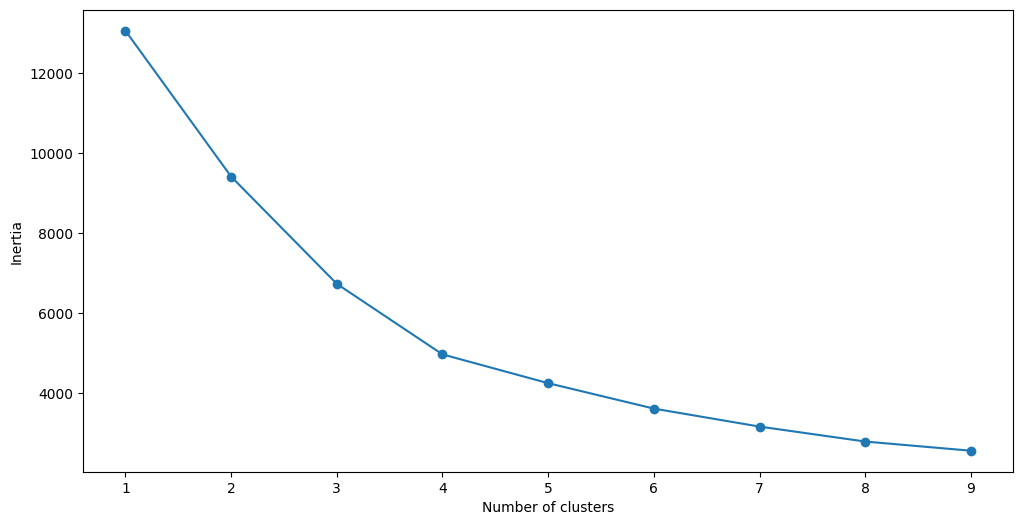

In [22]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')


In [23]:
# First, build a model with 4 clusters
kmeans = KMeans( n_clusters = 4, init='k-means++')
kmeans.fit(scaled_features)

/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4)

## Performance evaluation

To evaluate the performance of this model, we will use a metric called the silhouette score. This is a coefficient value that ranges from -1 to +1. A higher silhouette score is indicative of a better model.



In [24]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))


0.4360722849503388


## Segmentation model Interpretation and Visualization

In [25]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred

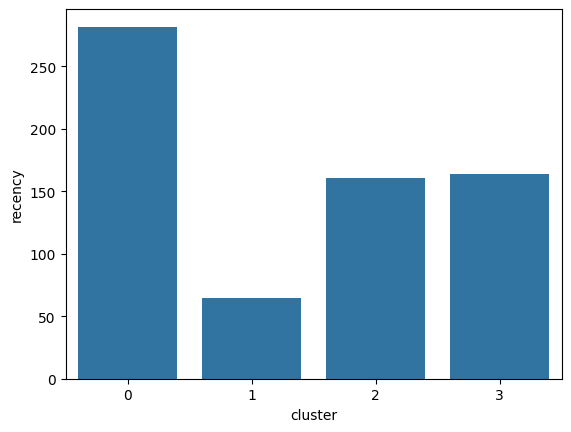

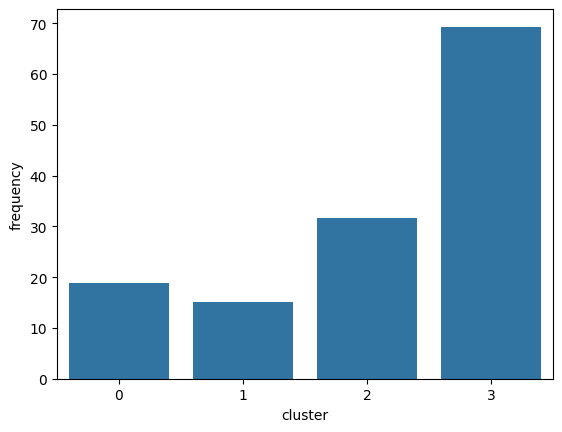

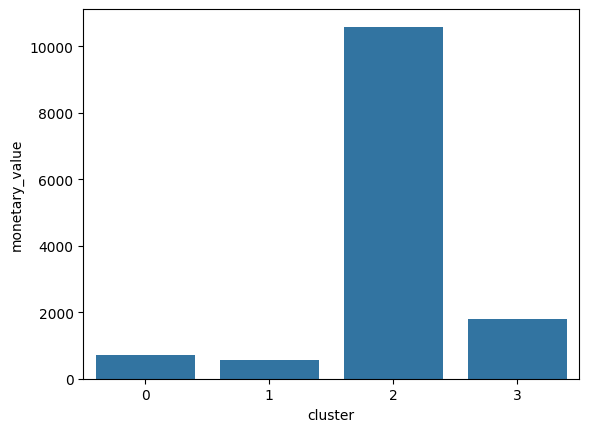

In [26]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
for i in list1:
    sns.barplot(x='cluster',y=str(i),data=avg_df)
    plt.show()